In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
from urllib.request import urlopen
from urllib.request import Request
import urllib3
import json
from IPython.core.display import display, HTML
from datetime import date

today = date.today()
date_today = today.strftime("%Y-%b")

http = urllib3.PoolManager()

url="https://api.msrc.microsoft.com/cvrf/"+date_today+"?api-version=2016-08-01"

r = http.request(
      'GET',
      url,
      headers={
          'api-key': 'c1fc8aedfdbd46e38bc1d74df765d251',
          'Accept': 'application/json'
      })
data=json.loads(r.data.decode('utf-8'))
display(HTML("<h1>"+data["DocumentTitle"]["Value"]+"</h1>"))
display(HTML(data["DocumentNotes"][0]["Value"]))


KB Article,Applies To
4534271,"Windows 10, version 1607, Windows Server 2016"
4534273,"Windows 10, version 1809, Windows Server version 1809, Windows 10, version 1809, Windows Server version 1809"
4534276,"Windows 10, version 1709"
4534283,Windows Server 2012 (Monthly Rollup)
4534288,Windows Server 2012 (Security-only update)
4534293,"Windows 10, version 1803, Windows Server version 1803"
4534297,"Windows 8.1, Windows Server 2012 R2 (Monthly Rollup)"
4534306,Windows 10
4534309,"Windows 8.1, Windows Server 2012 R2 (Security-only update)"


In [11]:
#<a href="(https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/.*">.+)</a>
#data["DocumentNotes"][0]["Value"]
import re

cve_urls=re.findall('<a href="https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/(.*)">.+</a>',data["DocumentNotes"][0]["Value"])

a=[]
i=0

for url in cve_urls:
    r = http.request('GET',"https://nvd.nist.gov/vuln/detail/"+url)
    b=re.findall('vuln-description">(.*)\'\.',r.data.decode('utf-8'))
    c=re.findall('CVSS v3.1 Severity and Metrics:&lt;/strong> &lt;p data-testid=&#39;vuln-cvssv3-score-container&#39;> &lt;strong>Base Score: &lt;/strong> &lt;span data-testid=&#39;vuln-cvssv3-base-score&#39;>(...)',r.data.decode('utf-8'))
    d=re.findall('vuln-description">.*aka(.*)\'\.',r.data.decode('utf-8'))
    a.append([url,b[0],c[0],d[0][2:]])
    
d=sorted(a, key=lambda x: (x[2]),reverse=True)

display(HTML("<table width=\"100%\"><thead><tr><th width=\"15%\">CVE</th><th width=\"5%\">Severity<br>(CVSSv3)</th><th width=\"20%\">Title</th><th>Description</th><th>URL</th><tr></thead><tbody>"))
for i in d:
  record=("<tbody><tr><td width=\"15%\">"+i[0]+"</td>")
  if float(i[2]) >= 9.0:
     record+=("<td width=\"5%\" bgcolor=\"mediumorchid\">")
  if float(i[2]) >= 7.0 and float(i[2]) < 9.0:
     record+=("<td width=\"5%\" bgcolor=\"#FF4F4F\">")
  if float(i[2]) >= 4.0 and float(i[2]) < 7.0:
     record+=("<td width=\"5%\" bgcolor=\"#FFA53F\">")
  if float(i[2]) >= 0.1 and float(i[2]) < 4.0:
     record+=("<td width=\"5%\" bgcolor=\"green\">")
  record+=(i[2]+"</td><td width=\"20%\">"+i[3]+"</td><td>"+i[1]+"</td><td><a href=\"https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/"+i[0]+"\">https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/"+i[0]+"</a><br><a href=\"https://nvd.nist.gov/vuln/detail/"+i[0]+"\">https://nvd.nist.gov/vuln/detail/"+i[0]+"</a></tr>")
  display(HTML(record))
display(HTML("</table>"))

CVE,Severity(CVSSv3),Title,Description,URL


CVE-2020-0609,9.8,Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Windows Remote Desktop Gateway (RD Gateway) when an unauthenticated attacker connects to the target system using RDP and sends specially crafted requests, aka 'Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability"


CVE-2020-0610,9.8,Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Windows Remote Desktop Gateway (RD Gateway) when an unauthenticated attacker connects to the target system using RDP and sends specially crafted requests, aka 'Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability"


CVE-2020-0654,9.1,Microsoft OneDrive for Android Security Feature Bypass Vulnerability,"A security feature bypass vulnerability exists in Microsoft OneDrive App for Android.This could allow an attacker to bypass the passcode or fingerprint requirements of the App.The security update addresses the vulnerability by correcting the way Microsoft OneDrive App for Android handles sharing links., aka 'Microsoft OneDrive for Android Security Feature Bypass Vulnerability"


CVE-2020-0601,8.1,Windows CryptoAPI Spoofing Vulnerability,"A spoofing vulnerability exists in the way Windows CryptoAPI (Crypt32.dll) validates Elliptic Curve Cryptography (ECC) certificates.An attacker could exploit the vulnerability by using a spoofed code-signing certificate to sign a malicious executable, making it appear the file was from a trusted, legitimate source, aka 'Windows CryptoAPI Spoofing Vulnerability"


CVE-2020-0650,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability"


CVE-2020-0651,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability"


CVE-2020-0652,7.8,Microsoft Office Memory Corruption Vulnerability,"A remote code execution vulnerability exists in Microsoft Office software when the software fails to properly handle objects in memory, aka 'Microsoft Office Memory Corruption Vulnerability"


CVE-2020-0653,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability"


CVE-2020-0612,7.5,Windows Remote Desktop Gateway (RD Gateway) Denial of Service Vulnerability,"A denial of service vulnerability exists in Windows Remote Desktop Gateway (RD Gateway) when an attacker connects to the target system using RDP and sends specially crafted requests, aka 'Windows Remote Desktop Gateway (RD Gateway) Denial of Service Vulnerability"


CVE-2020-0637,6.5,Remote Desktop Web Access Information Disclosure Vulnerability,"An information disclosure vulnerability exists when Remote Desktop Web Access improperly handles credential information, aka 'Remote Desktop Web Access Information Disclosure Vulnerability"


CVE-2020-0607,5.5,Microsoft Graphics Components Information Disclosure Vulnerability,"An information disclosure vulnerability exists in the way that Microsoft Graphics Components handle objects in memory, aka 'Microsoft Graphics Components Information Disclosure Vulnerability"


CVE-2020-0608,5.5,Win32k Information Disclosure Vulnerability,"An information disclosure vulnerability exists when the win32k component improperly provides kernel information, aka 'Win32k Information Disclosure Vulnerability"


CVE-2020-0615,5.5,Windows Common Log File System Driver Information Disclosure Vulnerability,"An information disclosure vulnerability exists in the Windows Common Log File System (CLFS) driver when it fails to properly handle objects in memory, aka 'Windows Common Log File System Driver Information Disclosure Vulnerability"


CVE-2020-0622,5.5,Microsoft Graphics Component Information Disclosure Vulnerability,"An information disclosure vulnerability exists when the Microsoft Windows Graphics Component improperly handles objects in memory, aka 'Microsoft Graphics Component Information Disclosure Vulnerability"


CVE-2020-0639,5.5,Windows Common Log File System Driver Information Disclosure Vulnerability,"An information disclosure vulnerability exists in the Windows Common Log File System (CLFS) driver when it fails to properly handle objects in memory, aka 'Windows Common Log File System Driver Information Disclosure Vulnerability"


CVE-2020-0643,5.5,Windows GDI+ Information Disclosure Vulnerability,"An information disclosure vulnerability exists in the way that the Windows Graphics Device Interface Plus (GDI+) handles objects in memory, allowing an attacker to retrieve information from a targeted system, aka 'Windows GDI+ Information Disclosure Vulnerability"


CVE-2020-0647,5.4,Microsoft Office Online Spoofing Vulnerability,"A spoofing vulnerability exists when Office Online does not validate origin in cross-origin communications correctly, aka 'Microsoft Office Online Spoofing Vulnerability"


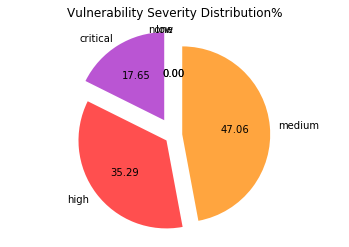

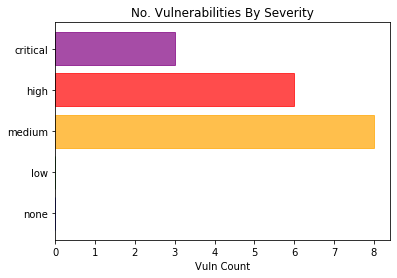

In [180]:
import matplotlib.pyplot as plotter
critical=0
high=0
medium=0
low=0
none=0

for i in d:
    if float(i[2]) >= 9.0:
        critical+=1
    if float(i[2]) >= 7.0 and float(i[2]) < 9.0:
        high+=1
    if float(i[2]) >= 4.0 and float(i[2]) < 7.0:
        medium+=1
    if float(i[2]) >= 0.1 and float(i[2]) < 4.0:
        low +=1
    if float(i[2]) < 0.1:
        none+=1
total=(critical+high+medium+low+none)        

pieLabels=['critical','high','medium','low','none']
severitypie=[critical,high,medium,low,none]

explodeTuple = (0.2, 0.1, 0.1, 0.1, 0.1)
figureObject, axesObject = plotter.subplots()
pie=axesObject.pie(severitypie, 
        explode=explodeTuple,
        labels=pieLabels,
        autopct='%1.2f',
        colors=['mediumorchid','#FF4F4F','#FFA53F','green','blue'],
        startangle=90)
axesObject.axis('equal')
plotter.title('Vulnerability Severity Distribution%')
plotter.show()

figureObject, axesObject    = plotter.subplots()
barlist = axesObject.barh(('none','low','medium','high','critical'),
        (none,low,medium,high,critical),
        0.8,
        alpha = 0.7,
        color = 'blue',
        label = 'Vulns')
barlist[0].set_color('blue')
barlist[1].set_color('green')
barlist[2].set_color('orange')
barlist[3].set_color('red')
barlist[4].set_color('purple')
axesObject.set_xlabel('Vuln Count')
plotter.title('No. Vulnerabilities By Severity')
plotter.show()